In [ ]:
from opensoundscape import Audio, Spectrogram

import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
def figsize(w,h):
    plt.rcParams['figure.figsize']=[w,h]
figsize(15,12) #for big visuals
%config InlineBackend.figure_format = 'retina'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
dataset_path = "../../../pam_dataset_v4"
all_cluster_samples = pd.read_csv(
    f"{dataset_path}/all_clips_with_cleaned_clusters.csv",
    parse_dates=["datetime", "date", "time"],
)
all_cluster_samples["features3d"] = all_cluster_samples["features3d"].apply(eval)
all_cluster_samples["time"] = all_cluster_samples["time"].apply(lambda x: x.time())
all_cluster_samples["date"] = all_cluster_samples["date"].apply(lambda x: x.date())
all_cluster_samples["year"] = all_cluster_samples["date"].apply(lambda x: x.year)
# all_cluster_samples["date"] = all_cluster_samples["file"].apply(
#     lambda x: audiomoth_start_time(x).date()
# )
# all_cluster_samples

/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_29767/2196131547.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_cluster_samples = pd.read_csv(


summary statistics of clusters

In [ ]:
n_clusters_per_point = all_cluster_samples.groupby("point_code").cluster_30.nunique()
n_clusters_per_point.min(), n_clusters_per_point.max(), n_clusters_per_point.median(), n_clusters_per_point.mean()

(1, 10, 4.0, 4.017094017094017)

In [ ]:
n_clusters_per_point = all_cluster_samples.groupby(
    "point_code"
).cluster_reviewed.nunique()
n_clusters_per_point.min(), n_clusters_per_point.max(), n_clusters_per_point.median(), n_clusters_per_point.mean()

(1, 9, 3.0, 3.4615384615384617)

In [5]:
all_cluster_samples.cluster_reviewed.nunique()

405

In [ ]:
cluster_summary = pd.read_csv(f"{dataset_path}/cluster_summary_reviewed.csv")
cluster_summary[cluster_summary.annotation == "n"].reason.value_counts()

reason
distant         64
mixed           18
not_ovenbird     7
Name: count, dtype: int64

In [ ]:
cluster_summary.annotation.str.contains("RK").fillna(False).sum()

/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_29767/1654967779.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cluster_summary.annotation.str.contains('RK').fillna(False).sum()


72

fraction of clips removed for being too distant to identify, or not belonging to the cluster

In [ ]:
n_clusters_kept = len(cluster_summary[cluster_summary.annotation != "n"])
n_samples_removed = 0
for i, row in cluster_summary[cluster_summary.annotation != "n"].iterrows():
    if row["clips_to_exclude"] != row["clips_to_exclude"]:
        continue
    else:
        n_samples_removed += len(row["clips_to_exclude"].split(","))
n_samples_removed / (n_clusters_kept * 10)

0.1293795620437956

In [ ]:
nyears_detected = all_cluster_samples.groupby("cluster_reviewed").year.nunique()
individuals_4yrs = list(nyears_detected[nyears_detected == 4].index)

opso todo: add ax option for Spectrogram.plot

In [ ]:
def plot_spec_on_ax(
    self,
    ax,
    inline=False,
    fname=None,
    show_colorbar=False,
    range=(-100, -20),
    kHz=True,
):
    """Plot the spectrogram with matplotlib.pyplot

    Args:
        inline=True:
        fname=None: specify a string path to save the plot to (ending in .png/.pdf)
        show_colorbar: include image legend colorbar from pyplot
        range: tuple of (min,max) values of .spectrogram to map to the lowest/highest
            pixel values. Values outside this range will be clipped to the min/max values
        kHz: bool [default:False] if True, y axis is plotted in units of kHz rather than Hz
    """
    norm = matplotlib.colors.Normalize(vmin=range[0], vmax=range[1])

    # if user specifies kHz=True, use kHz units rather than Hz on y axis
    y = self.frequencies / 1000 if kHz else self.frequencies
    ax.pcolormesh(
        self.times,
        y,
        self.spectrogram,
        shading="auto",
        cmap="Greys",
        norm=norm,
    )

    ax.set_xlabel("Time (sec)")
    ax.set_ylabel(f"Frequency ({'kHz' if kHz else 'Hz'})")
    if show_colorbar:
        plt.colorbar()

    # if fname is not None, save to file path fname
    if fname:
        plt.savefig(fname)

    # if not saving to file, check if a matplotlib backend is available
    if inline:
        plt.show()

plot songs across 4 years

/Users/SML161/miniconda3/envs/opso_dev/lib/python3.9/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


IndexError: index 5 is out of bounds for axis 0 with size 5

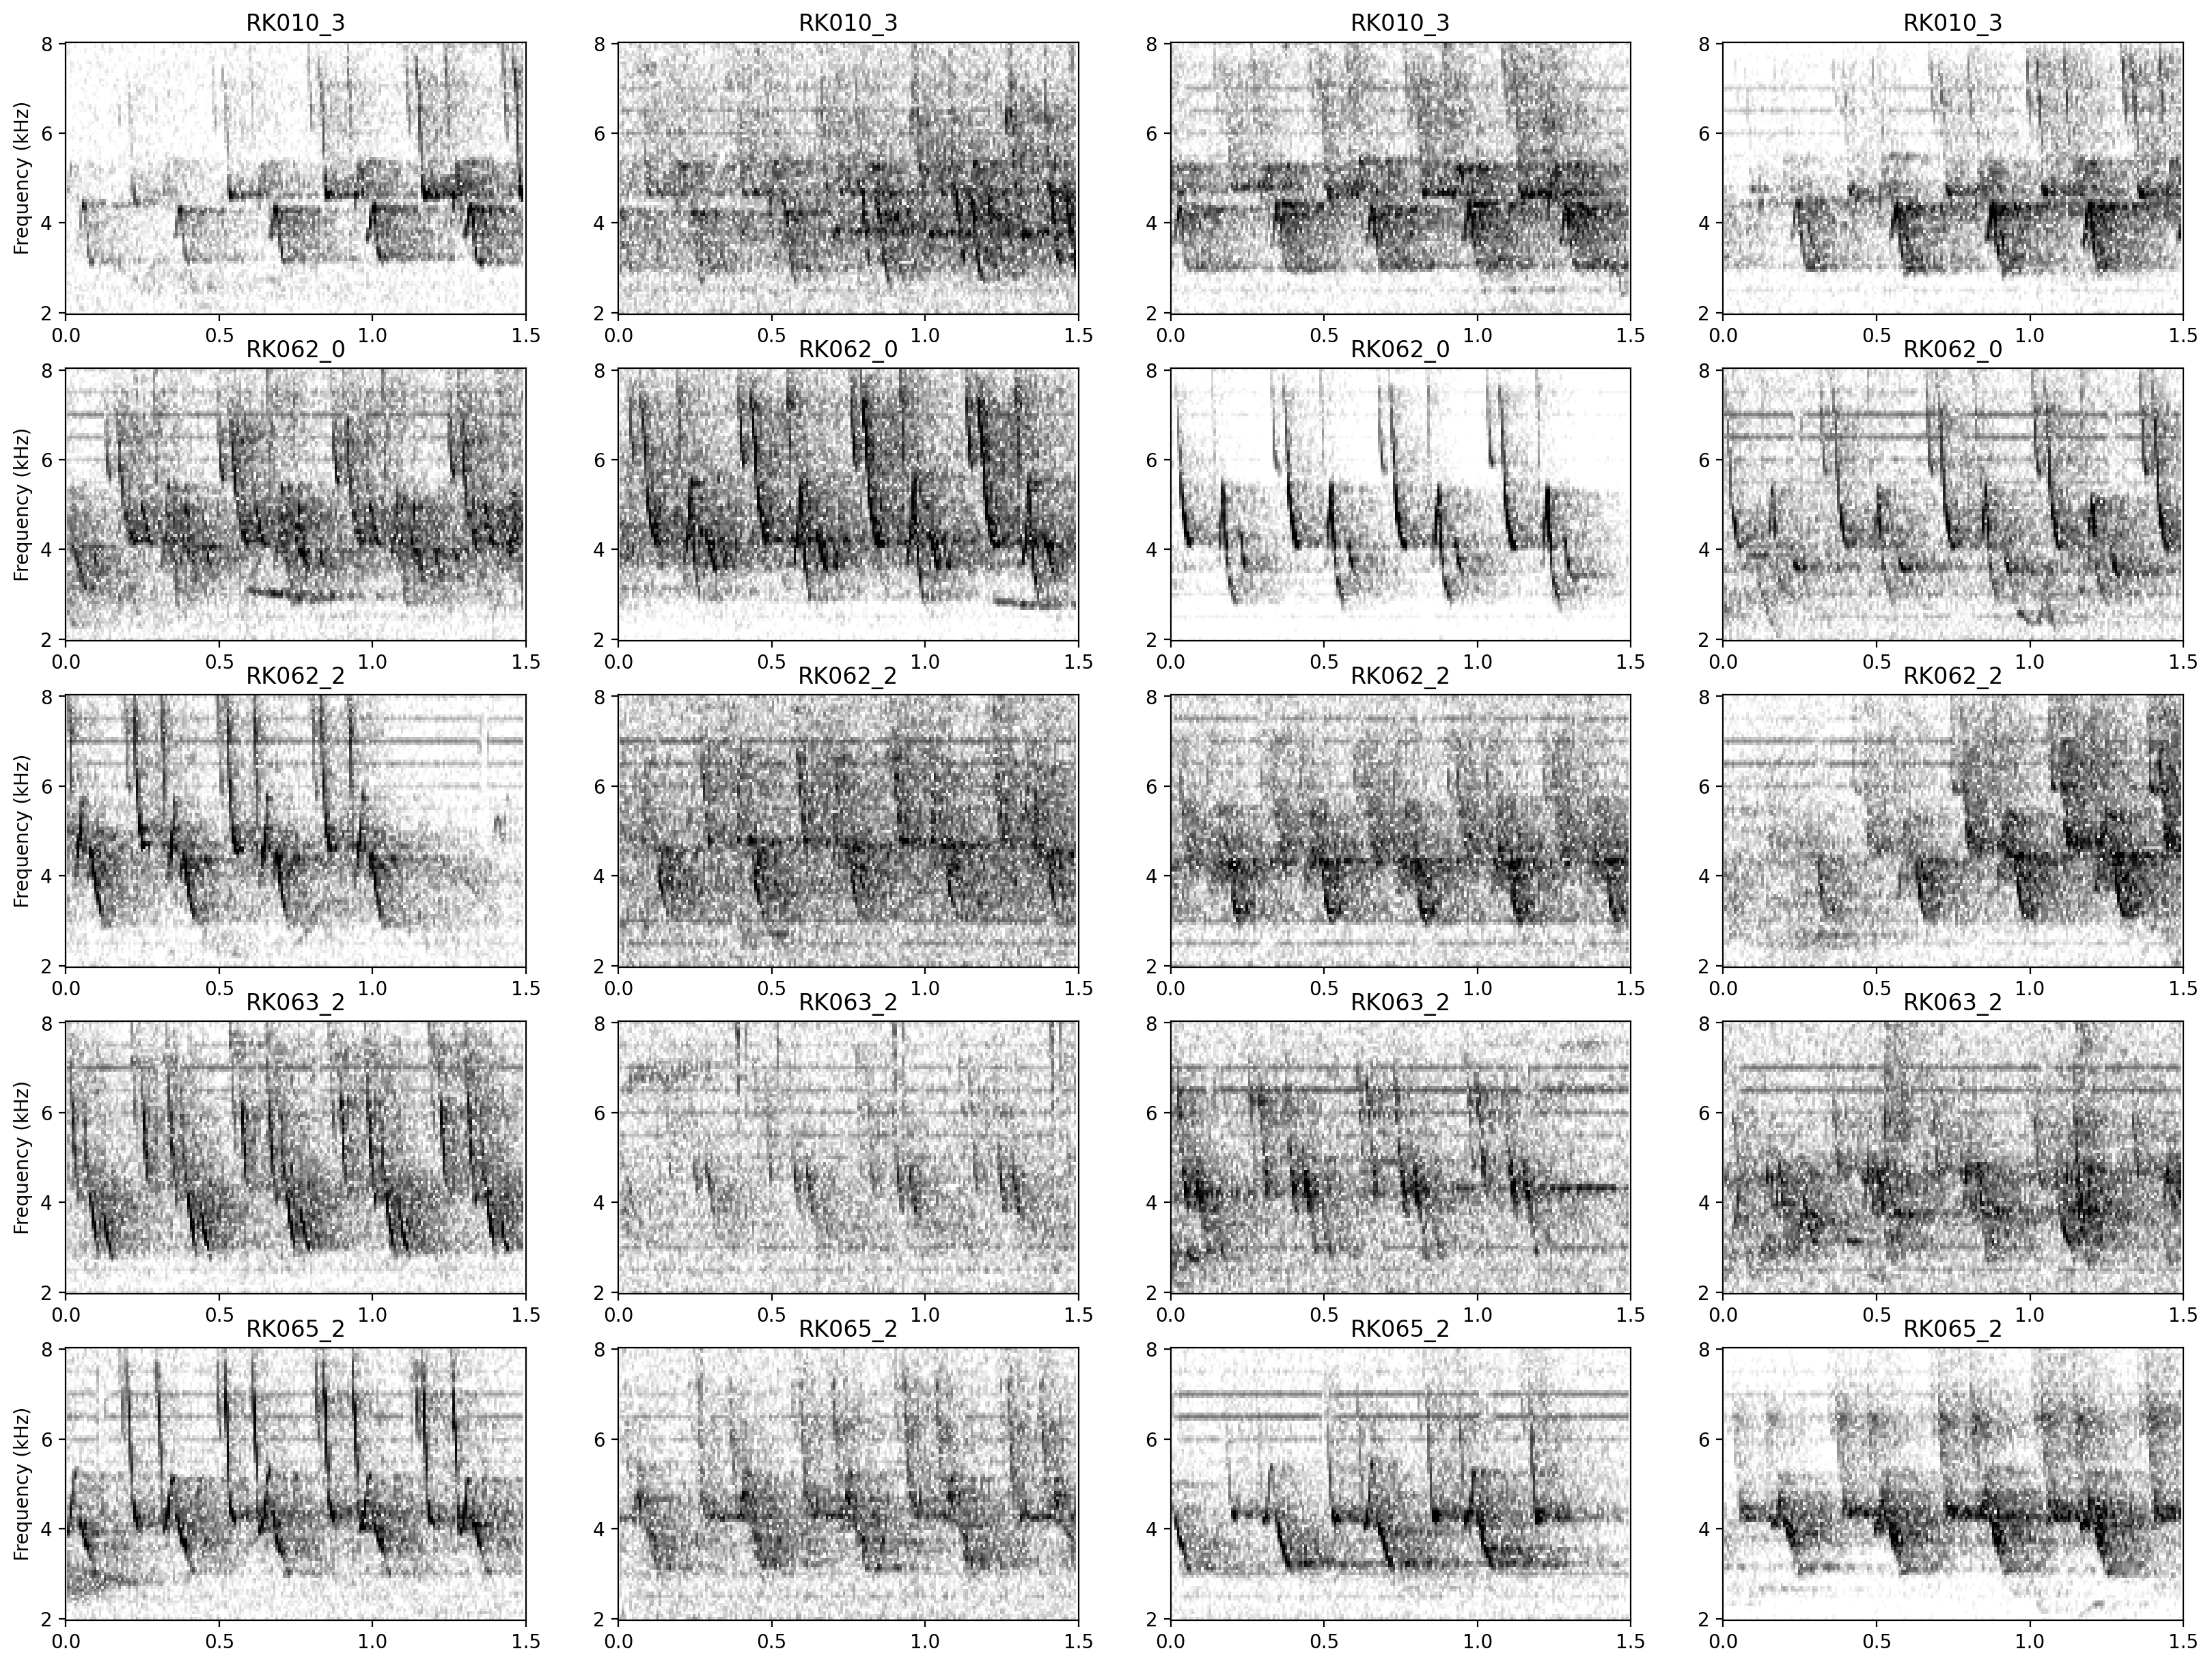

In [ ]:
figsize(20, 15)  # for big visuals

fig, axs = plt.subplots(5, 4)
for row_idx, c in enumerate(individuals_4yrs):
    samples = all_cluster_samples[all_cluster_samples.cluster_reviewed == c]
    for col_idx, year in enumerate([2021, 2022, 2023, 2024]):
        ax = axs[row_idx, col_idx]
        yr_samples = samples[samples["year"] == year]
        # select one
        if len(yr_samples) < 1:
            continue
        row = yr_samples.sample(1).iloc[0]
        path = f"{dataset_path}/audio/{row.clip_name}"
        a = Audio.from_file(path, offset=0.75, duration=1.5).normalize()
        s = Spectrogram.from_audio(a).bandpass(2000, 8000)
        plot_spec_on_ax(s, ax, range=[-55, -20])
        if not col_idx == 0:
            ax.set_ylabel(None)
        if not row_idx == 9:
            ax.set_xlabel(None)

        ax.set_xticks([0, 0.5, 1, 1.5])
        ax.set_yticks([2, 4, 6, 8])
        ax.set_title(row.cluster_reviewed)